# Homework 2 - eCommerce analytics
--------

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# [RQ1] Customer’s journey 

-------------

### What’s the operation users repeat more on average within a session?

In [2]:
cols = ['event_type','user_session']
df = pd.read_csv('~/Desktop/Datasets/2019-Oct.csv', usecols = cols)

In [4]:
event_series = df.groupby('event_type').event_type.count().to_frame('number_of_events').reset_index()
n = df['user_session'].nunique()
del df

,event_type,number_of_events
0,cart,926516
1,purchase,742849
2,view,40779399


In [5]:
event_series['avg_events'] = event_series.apply(lambda row: row.number_of_events /n, axis=1)

,event_type,number_of_events,avg_events
0,cart,926516,0.100224
1,purchase,742849,0.080356
2,view,40779399,4.411244


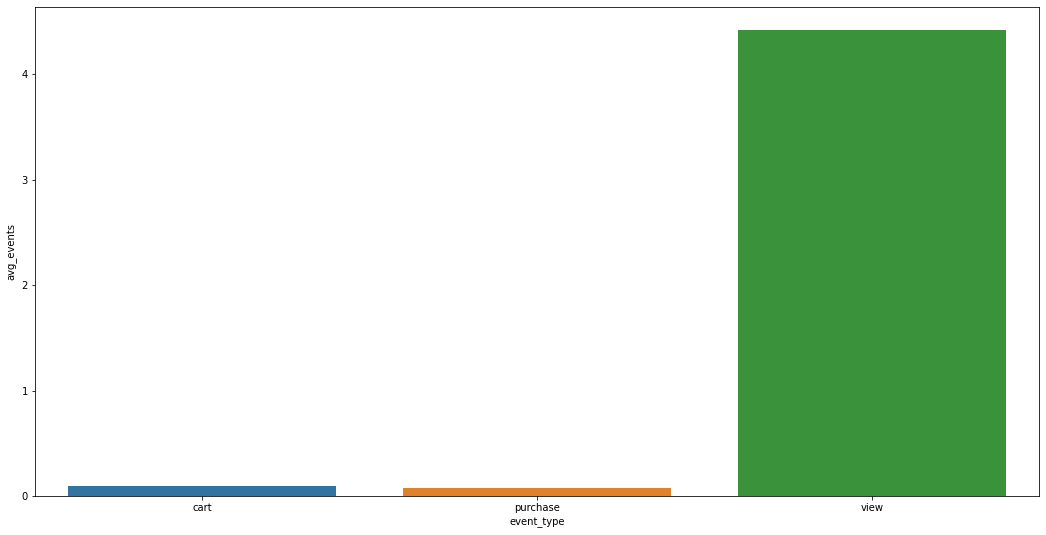

In [6]:
fig = plt.figure(figsize=(18,9))
plot = sns.barplot(x='event_type', y='avg_events', data=event_series)

As we could have expected, the views are by far the most repeated operation. We think that is because, in order to perform a cart or purchase operation a customer might has inevitably view the product.

### How many times, on average, a user views a product before adding it to the cart?

This analysis could have been performed in two ways: by computing the average number of views before every effectively bought article or, as we did, by computing the ratio between the number of `view` and the number of `cart` events. We think that including products that aren't bought provides us a more truthful insight on the number of views that are needed before we have a `cart` event. 

In [7]:
nviews = int(event_series[event_series.event_type == 'view']['number_of_events'])
ncarts = int(event_series[event_series.event_type == 'cart']['number_of_events'])
print('On average, products are seen', round(nviews/ncarts,3),'times before they are added to the cart.')

On average, products are seen 44.014 times before they are added to the cart.


### What’s the probability that products added once to the cart are effectively bought?

We make the same assumptions as before, so we compute an average probability.

In [8]:
npurchases = int(event_series[event_series.event_type == 'purchase']['number_of_events'])
print('The probability is estimated as:', round(npurchases/ncarts,4))
del event_series

The probability is estimated as: 0.8018


### What’s the average time an item stays in the cart before being removed?

### How much time passes on average between the first view time and a purchase/addition to cart?

In [30]:
cols = ['event_time','event_type','product_id','user_id']
df = pd.read_csv('~/Desktop/Datasets/2019-Oct.csv', parse_dates = ['event_time'], 
                 date_parser = pd.to_datetime,usecols = cols)
views = df[df.event_type == 'view']
carts = df[df.event_type == 'cart']
purchases = df[df.event_type == 'purchase']
del df

In [31]:
first_view = views.groupby(['user_id','product_id']).event_time.first().reset_index()
del views
first_cart = carts.groupby(['user_id','product_id']).event_time.first().reset_index()
del carts
first_purchase = purchases.groupby(['user_id','product_id']).event_time.first().reset_index()
del purchases

In [32]:
delta_views_carts = first_view.merge(first_cart , on=['user_id','product_id'])
delta_carts_purchases = first_cart.merge(first_purchase , on=['user_id','product_id'])
del first_view, first_cart, first_purchase, 
colnames = ['user_id','product_id','t1','t2']
delta_views_carts.columns = colnames
delta_carts_purchases.columns = colnames

In [33]:
delta_views_carts['delta'] = delta_views_carts.apply(lambda row: row.t2 - row.t1, axis = 1)
t = delta_views_carts['delta'].mean()
print('The average time between the first view and the first cart is:', t)
del delta_views_carts

delta_carts_purchases['delta'] = delta_carts_purchases.apply(lambda row: row.t2 - row.t1, axis = 1)
t = delta_carts_purchases['delta'].mean()
print('The average time between the first cart and the first purchase is:', t)
del delta_carts_purchases

The average time between the first view and the first cart is: 1 days 02:48:58.722720655
The average time between the first cart and the first purchase is: 0 days 00:38:51.650978489


# [RQ2] Sold products per category

---------

# [RQ3] Categories prices

-------

# [RQ4] How much does each brand earn per month?

------

# [RQ5] Hourly average visitors 

-------

# [RQ6] Conversion rate

--------

### Find the overall conversion rate of your store.


In this task we search for the overall conversion rate of the store i.e. the number of times a product has been bought over the number of times it has been visited.

In [96]:
cols = ['event_type','category_code','product_id']
df = pd.read_csv('~/Desktop/Datasets/2019-Oct.csv', usecols = cols)

In [97]:
# Creating subsets

views = df[df.event_type == 'view']
purchases = df[df.event_type == 'purchase']

In [98]:
# Conversion rate = number of purchases / number of views

conversion_rate = purchases['product_id'].count() / views['product_id'].count()
print('The overall conversion rate is:', round(conversion_rate,3))
del views, purchases

The overall conversion rate is: 0.018


### Plot the number of purchases of each category

In order to explore categories, we can look at the `category_id` or the `category_code` columns. We decided to use the second one because, even though it has a cosiderable amount of `NaN` values, it is more illustrative and meaningful to plot (there are less unique values). In fact we can look at the first level of each category (e.g. in `accessories.bag` we only need `accessories`).

In [99]:
# Extracting first level categories 

def fun(x):
    return str(x).split('.')[0]

df["category"]=df["category_code"].apply(fun)

In [100]:
# Now we create again the subsets to include the new column 

df_notNan = df[df.category != 'nan']
del df
views_notNan = df_notNan[df_notNan.event_type == 'view']
purchases_notNan = df_notNan[df_notNan.event_type == 'purchase']

In [101]:
d1 = purchases_notNan.groupby('category').event_type.count().reset_index().rename(columns =
                                         {'event_type':'purchases_number'})
del purchases_notNan

In [102]:
# Finding number of views for each category

d2 = views_notNan.groupby('category').event_type.count().reset_index().rename(columns =
                                                    {'event_type':'views_number'})
del views_notNan

In [103]:
# Joining dataframes in order to have the number of purchases and views for each category

dout = d1.merge(d2, on = 'category')
del d1,d2
dout.head(3)

,category,purchases_number,views_number
0,accessories,1587,236102
1,apparel,8002,1534896
2,appliances,74996,4799936


In [104]:
# Adding a third column that is a combination of the other two in order to find the c.r.

dout['conversion_rate'] = dout.apply(lambda row: 
                                     row.purchases_number / row.views_number, axis=1)

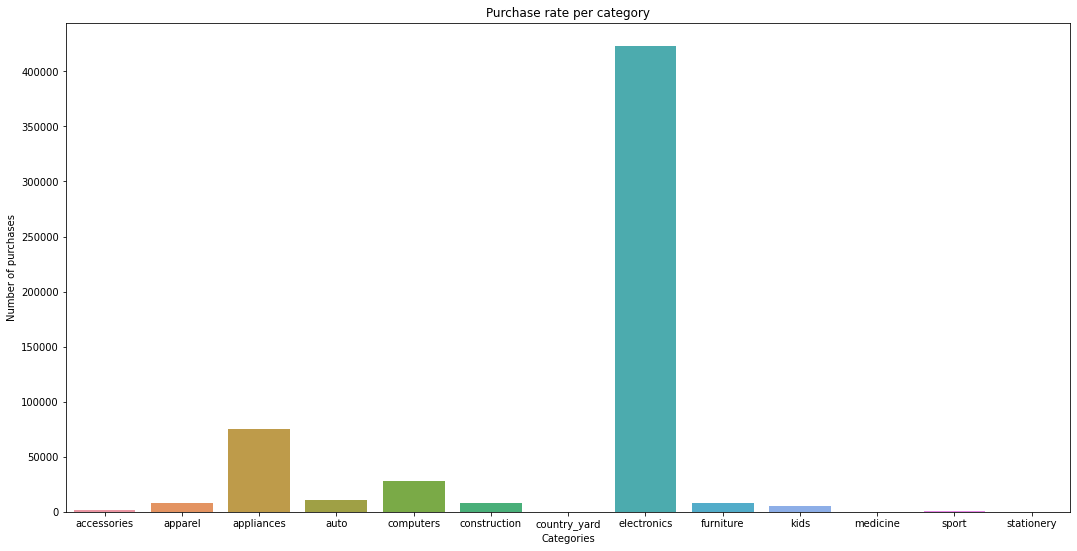

In [105]:
fig = plt.figure(figsize=(18,9))
plot = sns.barplot(x='category', y='purchases_number', data=dout)
plot.set(xlabel='Categories', ylabel='Number of purchases', title = 'Purchase rate per category')
plt.show()

The `electronics` category seems to be one with the bigger number of purchases by a lot while `medicine`,`country-yard` and `stationery` the less bought.

### Show the conversion rate of each category in decreasing order

In [106]:
# Sorting values

print(dout.sort_values(by='conversion_rate', ascending = False))
del dout

        category  purchases_number  views_number  conversion_rate
7    electronics            423028      15038390         0.028130
10      medicine               310         13974         0.022184
12    stationery               134          7380         0.018157
2     appliances             74996       4799936         0.015624
4      computers             27855       2268928         0.012277
5   construction              7801        712690         0.010946
9           kids              5482        512485         0.010697
3           auto             10620        993428         0.010690
11         sport              1236        174324         0.007090
0    accessories              1587        236102         0.006722
8      furniture              8301       1236452         0.006714
1        apparel              8002       1534896         0.005213
6   country_yard                72         13956         0.005159


Despite `medicine` and `stationery` have a relatively little number of purchases, they have a fairly high conversion rate. 

# [RQ7] The Pareto principle


---------------

### Prove that the Pareto principle applies to your store.

We want to prove the Pareto principle by contructing a column that computes the cumulative percetage sum of the revenue for each user and finding the one that corresponds to the 80% of the store revenue. 

In [45]:
cols = ['event_type','price','user_id']
df = pd.read_csv('~/Desktop/Datasets/2019-Oct.csv', usecols = cols)

In [46]:
# Grouping customers and computing total revenue (amount of money spent) for each one 

df = df[df.event_type == 'purchase']
customers = df.groupby('user_id').price.sum().to_frame('total_revenue').sort_values(
    by='total_revenue', ascending = False).reset_index()
del df

In [47]:
# Adding column with cumulative sum : cumul_sum[i] = cumul_sum[i-i] 

revenue = customers['total_revenue'].sum()
customers['cumul_sum'] = customers['total_revenue'].cumsum()

,user_id,total_revenue,cumul_sum
0,519267944,265569.52,265569.52
1,513117637,244500.00,510069.52
2,515384420,210749.77,720819.29


In [48]:
# Adding column with the percentage of the cumulative sum over the store revenue 

customers['percent_cumul_sum'] = customers.apply(lambda row: 
                                     round(row.cumul_sum / revenue,4)*100, axis=1)

,user_id,total_revenue,cumul_sum,percent_cumul_sum
0,519267944,265569.52,265569.52,0.12
1,513117637,244500.00,510069.52,0.22
2,515384420,210749.77,720819.29,0.31


In [49]:
pareto_index = customers[customers['percent_cumul_sum'] >= 80].index[0]
print('The', round((pareto_index/len(customers))*100,3),'percent of the users provides approximately the 80 percent of the store revenue.')

The 28.25 percent of the users provides approximately the 80 percent of the store revenue.


The *Pareto index* in the graphic below refers to the percentage of customers that provides the 80% of the store revenue.

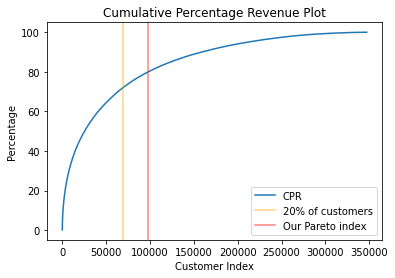

In [50]:
customers['percent_cumul_sum'].plot(label='CPR')
plt.figsize = (25,7)
plt.title('Cumulative Percentage Revenue Plot')
plt.ylabel('Percentage')
plt.xlabel('Customer Index')
plt.axvline(0.2*len(customers), label='20% of customers',color='orange',alpha=0.5)
plt.axvline(pareto_index, label='Our Pareto index',color='red',alpha=0.5)
plt.legend()

plt.show()
del customers

By looking at the distance between the yellow and the red line, we can affirm that the Pareto principle approximatively applies on our online store. 